# Testing on MNIST Dataset

In [1]:
import sys
sys.path.append("..")

In [2]:
## Enable/Disable Titles
show_titles = False

## Train a MLP on MNIST

In [3]:
import perceptrons.mnist as mnist

mnist_mlp = mnist.MNIST(
    [784, 32, 10],     # Architecture
    6,                      # Num. of Epochs
    128,                     # Batch Size
    "MNIST-mlp"             # MLP name
)

Epoch 1/6
375/375 [==============================] - 7s 18ms/step - loss: 1.3299 - accuracy: 0.7042 - val_loss: 0.8055 - val_accuracy: 0.8900
Epoch 2/6
375/375 [==============================] - 7s 18ms/step - loss: 0.8292 - accuracy: 0.8758 - val_loss: 0.7764 - val_accuracy: 0.9011
Epoch 3/6
375/375 [==============================] - 4s 10ms/step - loss: 0.8113 - accuracy: 0.8844 - val_loss: 0.8050 - val_accuracy: 0.8922
Epoch 4/6
375/375 [==============================] - 6s 15ms/step - loss: 0.8156 - accuracy: 0.8852 - val_loss: 0.7577 - val_accuracy: 0.9047
Epoch 5/6
375/375 [==============================] - 4s 10ms/step - loss: 0.7964 - accuracy: 0.8908 - val_loss: 0.7900 - val_accuracy: 0.8935
Epoch 6/6
375/375 [==============================] - 5s 14ms/step - loss: 0.8015 - accuracy: 0.8900 - val_loss: 0.7623 - val_accuracy: 0.8976


In [4]:
mnist_mlp.report()

~~ Reporting ~~
Parameters:
_________________________________________________________________
    Name:              MNIST-mlp
    In. Shape.:        (28, 28)
    Out Dim.:          10
    Architercture:     ListWrapper([784, 32, 10])
    Init.:             Training
    Activ. Func.:      ReLU
Layers:
_________________________________________________________________
    Name        In. Shape        Out. Shape          Weight Shape                  
    flatten     (28, 28)         (784,)              []                            
    dense_0     (784,)           (32,)               (784, 32)                     
    dense_1     (32,)            (10,)               (32, 10)                      
Metrics:
_________________________________________________________________
    Train Loss:        0.7808
    Train Accuracy:    0.8937
    Test Loss:         0.7699
    Test Accuracy:     0.8936





## Pre-Processing

In [5]:
import numpy as np
import geometry.interval as interval
import geometry.circle as circle
import matplotlib.pyplot as plt

InputDomain = interval.Interval(
    np.zeros(mnist_mlp.in_shape),
    np.ones(mnist_mlp.in_shape)
)

### Generate Inputs for each Class

In [6]:
## Get random points
N                   = 1000
RandomTestInputs    = mnist_mlp.random_points(N)

Inputs_per_class = []
for c in range(10):
    input_c = None
    ind     = 0
    while (input_c is None) and (ind <= N-1):
        input = RandomTestInputs[ind]
        if mnist_mlp.predict(input) == c:
            input_c = input
        ind += 1

    if input_c is not None:
        Inputs_per_class.append(input_c)
        input_c = None
    else:
        print("Error: Did not find input for class", c)

#### Visualization

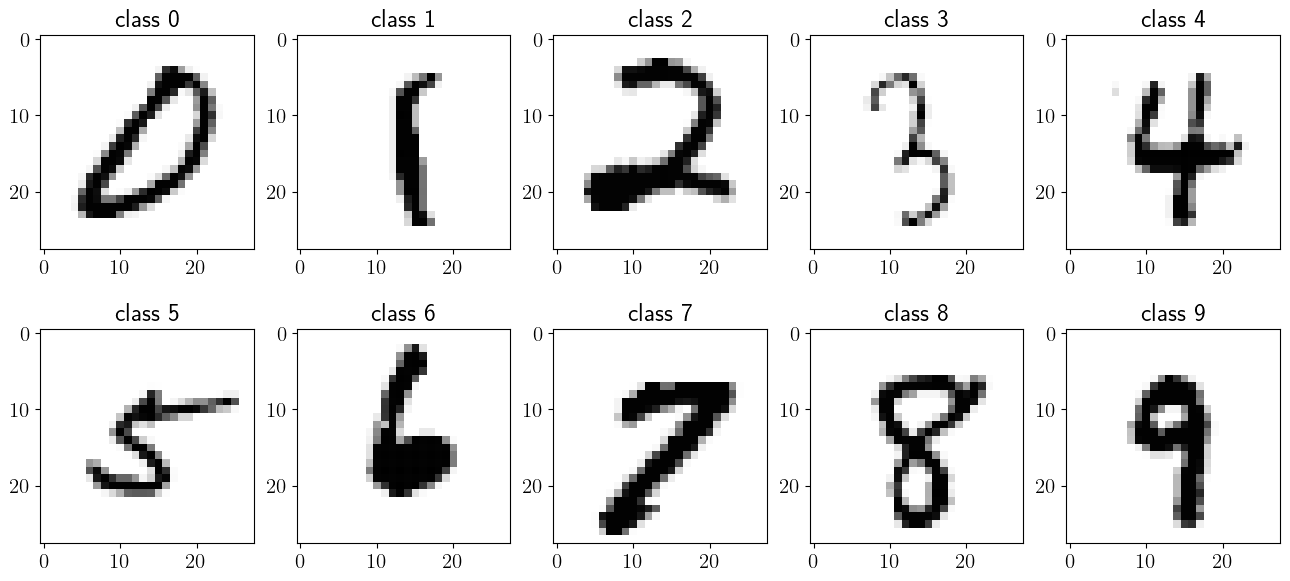

In [44]:
f, axarr = plt.subplots(2,5, figsize=(16, 7))

axarr[0, 0].imshow(Inputs_per_class[0], cmap="Greys", vmin=0.0, vmax=1.0)
axarr[0, 0].set_title("class 0")
axarr[0, 1].imshow(Inputs_per_class[1], cmap="Greys", vmin=0.0, vmax=1.0)
axarr[0, 1].set_title("class 1")
axarr[0, 2].imshow(Inputs_per_class[2], cmap="Greys", vmin=0.0, vmax=1.0)
axarr[0, 2].set_title("class 2")
axarr[0, 3].imshow(Inputs_per_class[3], cmap="Greys", vmin=0.0, vmax=1.0)
axarr[0, 3].set_title("class 3")
axarr[0, 4].imshow(Inputs_per_class[4], cmap="Greys", vmin=0.0, vmax=1.0)
axarr[0, 4].set_title("class 4")

axarr[1, 0].imshow(Inputs_per_class[5], cmap="Greys", vmin=0.0, vmax=1.0)
axarr[1, 0].set_title("class 5")
axarr[1, 1].imshow(Inputs_per_class[6], cmap="Greys", vmin=0.0, vmax=1.0)
axarr[1, 1].set_title("class 6")
axarr[1, 2].imshow(Inputs_per_class[7], cmap="Greys", vmin=0.0, vmax=1.0)
axarr[1, 2].set_title("class 7")
axarr[1, 3].imshow(Inputs_per_class[8], cmap="Greys", vmin=0.0, vmax=1.0)
axarr[1, 3].set_title("class 8")
axarr[1, 4].imshow(Inputs_per_class[9], cmap="Greys", vmin=0.0, vmax=1.0)
axarr[1, 4].set_title("class 9")

plt.show()

## Metrics

In [7]:
## tight divergence
def avg_tight_divergence(relu_scores, conv_scores):
    tight_divergence        = np.max(np.abs(relu_scores - conv_scores), 0)
    avg_tight_divergence    = np.sum(tight_divergence) / len(tight_divergence)

    return avg_tight_divergence

## misclassification
def misclassification_prob(relu_preds, conv_preds):
    misclassifications      = np.array(relu_preds) != np.array(conv_preds)
    misclassification_prob  = np.sum(misclassifications) / len(misclassifications)

    return misclassification_prob

## Increasing Radius per Class

###  Average Tight Divergence

#### Experiment

In [8]:
import perceptrons.convex as convex

In [48]:
import geometry.norms as norms

N = 10_000

avg_tight_divergence_per_class  = []    # a 2D array containing the average,
                                        # per class, per radius
worst_ub_per_class              = []    # a 2D array containing the worst case,
                                        # UB, per class, per radius

for c in range(10):

    avg_tight_divergence_per_radius = []
    worst_ub_per_radius             = []
    for rad in np.arange(0, 1.1, 0.1):
        ## Create Vicinity
        center      = Inputs_per_class[c]
        vicinity    = circle.InfCircle(center, rad).get_interval() & InputDomain

        ## Generate Inputs
        RandomInputs = vicinity.random_points(N)

        ## Generate Tight Conv. Approx. for Vicinity
        conv_approx = convex.ConvexApprox(
                        mnist_mlp,
                        vicinity
                    )
        
        ## Calculate Scores
        relu_scores = mnist_mlp.scores(RandomInputs)
        conv_scores = conv_approx.scores(RandomInputs)

        ## Calculate Metrics
        atd = avg_tight_divergence(relu_scores, conv_scores)
        avg_tight_divergence_per_radius.append(atd)

        ## Calculate worst case UB
        UB = conv_approx.propagate_bounds(vicinity)[0][-1].ub
        UB = np.max(np.abs(UB))
        worst_ub_per_radius.append(UB)

    
    avg_tight_divergence_per_class.append(avg_tight_divergence_per_radius)
    worst_ub_per_class.append(worst_ub_per_radius)


print(avg_tight_divergence_per_class)
print(worst_ub_per_class)

[[0.0, 0.5784923553466796, 2.2947975158691407, 3.881246566772461, 5.396833419799805, 6.807518005371094, 8.099797821044922, 9.33200454711914, 10.504567718505859, 11.581999206542969, 12.547187042236327], [0.0, 1.1729896545410157, 2.7993404388427736, 4.324624252319336, 5.723992156982422, 7.004039764404297, 8.191801452636719, 9.348719787597656, 10.476871490478516, 11.562490081787109, 12.547187042236327], [0.0, 0.7029540061950683, 2.2563859939575197, 3.766964340209961, 5.42535514831543, 6.747643280029297, 8.03685302734375, 9.288625335693359, 10.484083557128907, 11.57926025390625, 12.547187042236327], [0.0, 1.3202200889587403, 2.9387115478515624, 4.375012969970703, 5.688547897338867, 6.9543304443359375, 8.188674163818359, 9.379106140136718, 10.507223510742188, 11.567115020751952, 12.547187042236327], [0.0, 1.1477149963378905, 2.837325668334961, 4.5569499969482425, 5.993782043457031, 7.328617858886719, 8.544906616210938, 9.69070053100586, 10.727771759033203, 11.675926208496094, 12.54718704223

#### Visualization

In [10]:
import matplotlib.colors as mcolors
colors_per_class = list(mcolors.TABLEAU_COLORS.keys())

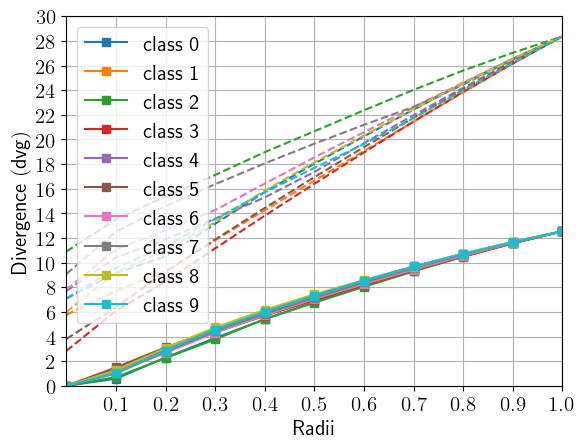

In [59]:
## Latex
plt.rcParams['text.usetex'] = True

## show UB
show_ub = True

## log plots
plt.rcParams.update({'font.size': 15})
ax = plt.axes()



radii = np.arange(0, 1.1, 0.1)
for c in range(10):
    plt.plot(
        radii,
        avg_tight_divergence_per_class[c],
        label="class " + str(c),
        linestyle = "-",
        color = colors_per_class[c],
        marker="s"
    )
    if show_ub:
        plt.plot(
            radii,
            worst_ub_per_class[c],
            #label="class " + str(c),
            linestyle = "--",
            color = colors_per_class[c],
            #marker="s"
        )   

plt.legend()
plt.grid(True)
if show_titles: plt.title("Average Tight Divergence\n w.r.t. Increasing Radii")
plt.ylabel("Divergence $(\mathsf{dvg})$")
plt.xlabel("Radii")

plt.xticks(np.arange(0.1, 1.1, 0.1))
if show_ub:
    plt.yticks(np.arange(0, 32, 2))
    ax.set(xlim=(0, 1), ylim=(0, 30))
else:
    plt.yticks(np.arange(0, 14))
    ax.set(xlim=(0, 1), ylim=(0, 13))

plt.show()

### Counting Misclassifications

#### Experiment

In [12]:
N = 10_000

missclassification_prob_per_class = []

for c in range(10):

    missclassification_prob_per_radius = []
    for rad in np.arange(0, 1.1, 0.1):
        ## Create Vicinity
        center      = Inputs_per_class[c]
        vicinity    = circle.InfCircle(center, rad).get_interval() & InputDomain

        ## Generate Inputs
        RandomInputs = vicinity.random_points(N)

        ## Generate Tight Conv. Approx. for Vicinity
        conv_approx = convex.ConvexApprox(
                        mnist_mlp,
                        vicinity
                    )
        
        ## Calculate Scores
        relu_preds = mnist_mlp.predict(RandomInputs)
        conv_preds = conv_approx.predict(RandomInputs)

        ## Calculate Metrics
        mcp = misclassification_prob(relu_preds, conv_preds)
        missclassification_prob_per_radius.append(mcp)
    
    missclassification_prob_per_class.append(missclassification_prob_per_radius)


#print(missclassification_prob_per_class)

#### Visualization

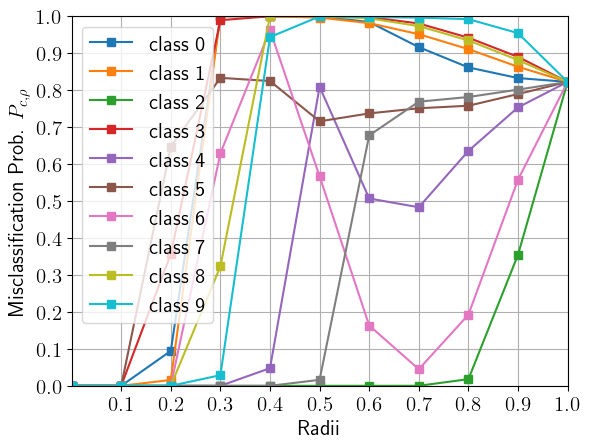

In [17]:
## Latex
plt.rcParams['text.usetex'] = True

## log plots
plt.rcParams.update({'font.size': 15})
ax = plt.axes()



radii = np.arange(0, 1.1, 0.1)
for c in range(10):
    plt.plot(
        radii,
        missclassification_prob_per_class[c],
        label="class " + str(c),
        linestyle = "-",
        color = colors_per_class[c],
        marker="s"
    )

plt.legend()
plt.grid(True)
if show_titles: plt.title("Misclassification Probability\n w.r.t. Increasing Radii")
plt.ylabel("Misclassification Prob. $P_{c, \\rho}$")
plt.xlabel("Radii")

plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
ax.set(xlim=(0, 1), ylim=(0, 1))
plt.show()